# Import Libraries

In [236]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Read in Data and Split in Test and Train

In [347]:
df = pd.read_csv("bank+marketing/bank/bank_preprocessed.csv")
X = df.drop(columns = "y")
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [348]:
print ("Number of training examples: " + str(X_train.shape[0]))
print ("Number of testing examples: " + str( X_test.shape[0]))
print ("Number of features = " + str(X_train.shape[1]))

Number of training examples: 3616
Number of testing examples: 905
Number of features = 43


# Define Functions for Neural Network

In [239]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape
    Y -- labels of shape
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # output layer size
    return (n_x, n_h, n_y)

def sigmoid(z):
    z = np.array(z, dtype=np.float64)
    z = np.clip(z, -500, 500)
    s = 1 / (1 + np.exp(-z))
    return s

def tanh(z):
    z = np.array(z, dtype=np.float64)
    z = np.clip(z, -500, 500)
    t = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    return t

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(42)
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
        
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

def compute_cost(A2, Y, parameters, class_weights):
    """
    Computes the weighted cross-entropy cost
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing parameters W1, b1, W2 and b2
    class_weights -- list or array containing weights for each class [weight_for_0, weight_for_1]
    
    Returns:
    cost -- weighted cross-entropy
    """
    m = Y.shape[1]  

    A2 = np.clip(A2, 1e-8, 1 - 1e-8)

    logprobs = np.multiply(Y, np.log(A2)) * class_weights[1] + np.multiply(1 - Y, np.log(1 - A2)) * class_weights[0]
    cost = -np.sum(logprobs) / m

    cost = float(np.squeeze(cost))
    assert(isinstance(cost, float))
    
    return cost


def backward_propagation(parameters, cache, X, Y):
    """
    Arguments:
    parameters -- python dictionary containing parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data
    Y -- "true" labels
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims = True)
    
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis = 1, keepdims = True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads


def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent
    
    Arguments:
    parameters -- python dictionary
    grads -- python dictionary containing gradients 
    
    Returns:
    parameters -- python dictionary containing updated parameters 
    """

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [326]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 0.1,  print_cost=False):    
    
    np.random.seed(42)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    if len(np.unique(Y)) > 2:
        class_weights = [1, 1]
        for i in range(len(np.unique(Y))):
            class_weights[i] = 1 / (np.sum(Y == i) / Y.shape[0])
        class_weights = np.array(class_weights)
    else:
        class_weights = [1, 1]
    
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(0, num_iterations):
         
        A2, cache = forward_propagation(X, parameters)       
        cost = compute_cost(A2, Y, parameters, class_weights=class_weights)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [327]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5).astype(int)
    return predictions

# Shape and Normalize Input Data

In [349]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [350]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_train = y_train.reshape(1, y_train.shape[0])
y_test = y_test.to_numpy()
y_test = y_test.reshape(1, y_test.shape[0])
X_train = X_train.T
X_test = X_test.T
X_train_scaled = X_train_scaled.T
X_test_scaled = X_test_scaled.T

In [351]:
y_train.shape

(1, 3616)

# Apply to data

### Berechne auf Skalierten Daten

 Berechnung mit Nicht-Normierten Daten ist nicht möglich!

In [245]:
all_results = []	

Schränke Parameter ein  

In [352]:
y_test = pd.Series(y_test[0].flatten())

In [283]:
all_results = []

In [308]:
results = []  
learning_rates = [1.0, 0.5]
num_iterations = 10000
#nh between 1 and 44

for lr in learning_rates:
    predictions = np.zeros((1, X_test.shape[1]))
    for n_h in range(20, 31):
        parameters = nn_model(X_train_scaled, y_train, n_h=n_h, num_iterations=num_iterations, learning_rate=lr, print_cost=False)
        predictions = predict(parameters, X_test_scaled)
        y_pred = pd.Series(predictions[0].flatten())
        roc_value = roc_auc_score(y_test, y_pred)
        
        if predictions.sum() > 1 and roc_value > 0.5:
            results.append({
                "n_h": n_h,
                "num_iterations": num_iterations,
                "learning_rate": lr,
                "parameters": parameters,
                "roc_auc": np.round(roc_value,3),
                "predictions": predictions
            })

In [309]:
print("Gefundene Kombinationen")
for result in results:
    print(f"n_h: {result['n_h']}, learning_rate: {result['learning_rate']}, roc_auc: {result['roc_auc']}")

Gefundene Kombinationen
n_h: 20, learning_rate: 1.0, roc_auc: 0.68
n_h: 21, learning_rate: 1.0, roc_auc: 0.687
n_h: 22, learning_rate: 1.0, roc_auc: 0.681
n_h: 23, learning_rate: 1.0, roc_auc: 0.7
n_h: 24, learning_rate: 1.0, roc_auc: 0.71
n_h: 25, learning_rate: 1.0, roc_auc: 0.676
n_h: 26, learning_rate: 1.0, roc_auc: 0.686
n_h: 27, learning_rate: 1.0, roc_auc: 0.683
n_h: 28, learning_rate: 1.0, roc_auc: 0.625
n_h: 29, learning_rate: 1.0, roc_auc: 0.665
n_h: 30, learning_rate: 1.0, roc_auc: 0.708
n_h: 20, learning_rate: 0.5, roc_auc: 0.657
n_h: 21, learning_rate: 0.5, roc_auc: 0.686
n_h: 22, learning_rate: 0.5, roc_auc: 0.679
n_h: 23, learning_rate: 0.5, roc_auc: 0.672
n_h: 24, learning_rate: 0.5, roc_auc: 0.657
n_h: 25, learning_rate: 0.5, roc_auc: 0.648
n_h: 26, learning_rate: 0.5, roc_auc: 0.719
n_h: 27, learning_rate: 0.5, roc_auc: 0.69
n_h: 28, learning_rate: 0.5, roc_auc: 0.668
n_h: 29, learning_rate: 0.5, roc_auc: 0.718
n_h: 30, learning_rate: 0.5, roc_auc: 0.672


In [310]:
if all_results is None:
    all_results = []

all_results.extend(results)

In [311]:
df_all_results = pd.DataFrame(all_results).sort_values(by= "roc_auc", ascending=False)
df_all_results

,n_h,num_iterations,learning_rate,parameters,roc_auc,predictions
83,26,5000,0.5,"{'W1': [[-0.46781423540417605, -0.051982118491...",0.730,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,..."
105,26,10000,0.5,"{'W1': [[-0.5524915188656926, -0.0325486986306...",0.719,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,..."
108,29,10000,0.5,"{'W1': [[-0.1358470245215516, -0.1216068018506...",0.718,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,..."
86,29,5000,0.5,"{'W1': [[-0.12861289032140458, -0.087826607526...",0.711,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,..."
70,24,5000,1.0,"{'W1': [[0.476109091542716, -0.102687471528040...",0.710,"[[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,..."
...,...,...,...,...,...,...
17,26,50,0.5,"{'W1': [[0.01538941028753997, 0.00861402920379...",0.641,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
74,28,5000,1.0,"{'W1': [[-0.586957330635504, -0.30453847188585...",0.641,"[[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,..."
12,21,50,0.5,"{'W1': [[0.029997782284924165, 0.0146149722101...",0.626,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
20,29,50,0.5,"{'W1': [[0.006276225594026928, 4.8008225407822...",0.626,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."


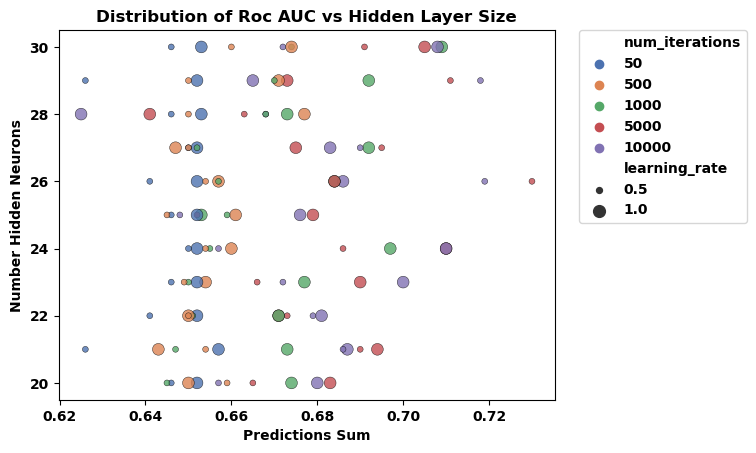

In [312]:
sns.scatterplot(data=df_all_results, x="roc_auc", y="n_h", hue="num_iterations", alpha=0.8, palette="deep", size="learning_rate", edgecolor="black")
plt.title("ROC AUC vs Hidden Layer Size")
plt.xlabel("Predictions Sum")
plt.ylabel("Number Hidden Neurons")
plt.title("Distribution of Roc AUC vs Hidden Layer Size")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [314]:
#df_all_results.to_csv("bank+marketing/bank/gridsearch_manual_singlelayer.csv", index=False)
df_test = pd.read_csv("bank+marketing/bank/gridsearch_manual_singlelayer.csv")

In [329]:
df_test.sort_values(by= "roc_auc", ascending=False)

,n_h,num_iterations,learning_rate,parameters,roc_auc,predictions
0,26,5000,0.5,"{'W1': array([[-0.46781424, -0.05198212, -0.21...",0.730,[[0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 ...
1,26,10000,0.5,"{'W1': array([[-0.55249152, -0.0325487 , -0.20...",0.719,[[0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 ...
2,29,10000,0.5,"{'W1': array([[-0.13584702, -0.1216068 , -0.46...",0.718,[[0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 ...
3,29,5000,0.5,"{'W1': array([[-1.28612890e-01, -8.78266075e-0...",0.711,[[0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 ...
4,24,5000,1.0,"{'W1': array([[ 0.47610909, -0.10268747, -0.95...",0.710,[[0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 ...
...,...,...,...,...,...,...
105,26,50,0.5,"{'W1': array([[ 0.01538941, 0.00861403, 0.00...",0.641,[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 ...
106,28,5000,1.0,"{'W1': array([[-0.58695733, -0.30453847, 0.00...",0.641,[[0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 ...
107,21,50,0.5,"{'W1': array([[ 2.99977823e-02, 1.46149722e-0...",0.626,[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 ...
108,29,50,0.5,"{'W1': array([[ 6.27622559e-03, 4.80082254e-0...",0.626,[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 ...


# Berechne Model für beste Parameter

In [331]:
parameters = nn_model(X_train_scaled, y_train, n_h=26, num_iterations=10000, learning_rate=0.5, print_cost=True)
predictions = predict(parameters, X_test_scaled)

Cost after iteration 0: 0.693129
Cost after iteration 1000: 0.167362
Cost after iteration 2000: 0.085016
Cost after iteration 3000: 0.040228
Cost after iteration 4000: 0.021251
Cost after iteration 5000: 0.013600
Cost after iteration 6000: 0.009640
Cost after iteration 7000: 0.007293
Cost after iteration 8000: 0.005758
Cost after iteration 9000: 0.004695


In [361]:
parameters = nn_model(X_train_scaled, y_train, n_h=26, num_iterations=30000, learning_rate=0.2, print_cost=True)
predictions = predict(parameters, X_test_scaled)

Cost after iteration 0: 0.693129
Cost after iteration 1000: 0.212880
Cost after iteration 2000: 0.186634
Cost after iteration 3000: 0.145483
Cost after iteration 4000: 0.110864
Cost after iteration 5000: 0.084513
Cost after iteration 6000: 0.062797
Cost after iteration 7000: 0.046179
Cost after iteration 8000: 0.034592
Cost after iteration 9000: 0.026647
Cost after iteration 10000: 0.021271
Cost after iteration 11000: 0.017553
Cost after iteration 12000: 0.014869
Cost after iteration 13000: 0.012829
Cost after iteration 14000: 0.011208
Cost after iteration 15000: 0.009883
Cost after iteration 16000: 0.008786
Cost after iteration 17000: 0.007875
Cost after iteration 18000: 0.007110
Cost after iteration 19000: 0.006464
Cost after iteration 20000: 0.005911
Cost after iteration 21000: 0.005435
Cost after iteration 22000: 0.005022
Cost after iteration 23000: 0.004660
Cost after iteration 24000: 0.004340
Cost after iteration 25000: 0.004056
Cost after iteration 26000: 0.003803
Cost after ite

In [362]:
y_pred = pd.Series(predictions[0].flatten())
roc_value = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", np.round(roc_value, 3))

ROC AUC:  0.714


In [363]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       807
           1       0.49      0.49      0.49        98

    accuracy                           0.89       905
   macro avg       0.71      0.71      0.71       905
weighted avg       0.89      0.89      0.89       905



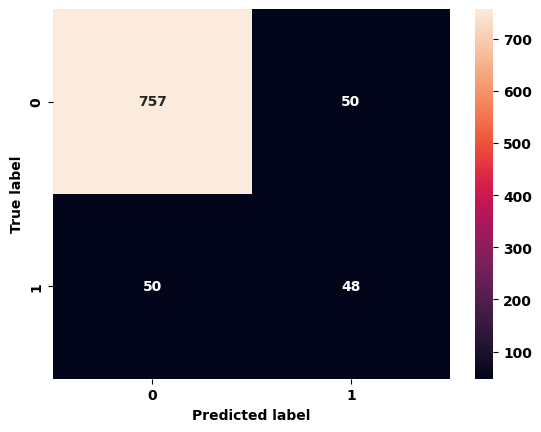

In [364]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

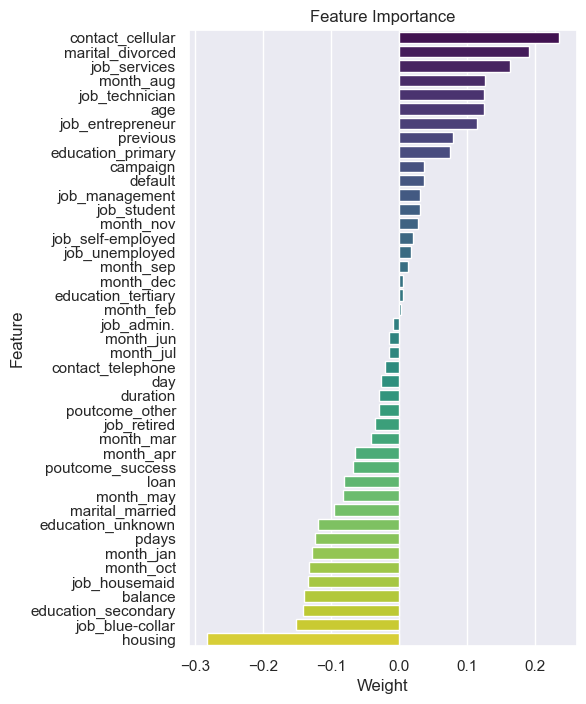

In [376]:
weights = np.sum(np.abs(parameters["W1"]), axis=0)
weights = np.median((parameters["W1"]), axis=0)
cols = df.drop(columns = ["y"]).columns.to_list()
features = pd.DataFrame({"feature": cols, "weight": weights}).sort_values(by="weight", ascending=False)

sns.set(rc={'figure.figsize': (5, 8)})
sns.barplot(data=features, x="weight", y="feature", palette="viridis")
plt.title("Feature Importance")
plt.xlabel("Weight")
plt.ylabel("Feature")
plt.show()